In [1]:
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
# excel = pd.read_csv(f'./HRDataset_v14.csv')
# excel = pd.read_excel(f'./fix_data_karyawan_2223_v2.xlsx')
excel = pd.read_excel(f'./fix_data_karyawan_24_v2.xlsx')
excel = pd.DataFrame(excel)
excel.head(5)

,NAMA,KARY_TYPE,STATUS,MULAI_KERJA,TGL_KELUAR,UMUR,JENIS_KELAMIN,STS_NIKAH,T,LDI,...,CP,CN,CL,CB,CSJ,TERMINATED,LAMA_KERJA,GAJI,PENILAIAN_KINERJA,KOTA_TINGGAL
0,Rin,TD,A,1996-02-01,NaT,55,Wanita,Belum Menikah,228,0,...,6,0,0,0,0,0,29.40,14050000,3.29,Surabaya
1,Ach,TD,A,1999-05-03,NaT,50,Pria,Menikah,229,0,...,6,0,0,0,0,0,26.15,15450000,3.39,Surabaya
2,Agd,TD,A,2014-03-03,NaT,45,Pria,Menikah,234,0,...,0,0,0,0,0,0,11.32,13650000,3.29,Surabaya
3,Anj,TD,A,1996-10-01,NaT,52,Pria,Menikah,229,0,...,3,0,0,0,0,0,28.74,16750000,3.09,Surabaya
4,Ant,TD,A,1989-12-01,NaT,63,Pria,Menikah,235,0,...,6,0,0,0,0,0,35.57,15500000,2.17,Surabaya


In [4]:
excel.columns

Index(['NAMA', 'KARY_TYPE', 'STATUS', 'MULAI_KERJA', 'TGL_KELUAR', 'UMUR',
       'JENIS_KELAMIN', 'STS_NIKAH', 'T', 'LDI', 'LTI', 'I', 'S', 'A', 'D',
       'CD', 'CP', 'CN', 'CL', 'CB', 'CSJ', 'TERMINATED', 'LAMA_KERJA', 'GAJI',
       'PENILAIAN_KINERJA', 'KOTA_TINGGAL'],
      dtype='object')

In [5]:
excel.shape

(201, 26)

In [6]:
excel.describe()

,MULAI_KERJA,TGL_KELUAR,UMUR,T,LDI,LTI,I,S,A,D,CD,CP,CN,CL,CB,CSJ,TERMINATED,LAMA_KERJA,GAJI,PENILAIAN_KINERJA
count,201,13,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.0,201.000000,201.000000,2.010000e+02,201.000000
mean,2008-09-20 13:51:02.686567168,2024-06-25 20:18:27.692307712,43.358209,162.940299,6.099502,0.243781,1.199005,2.796020,1.910448,2.213930,0.049751,5.039801,0.024876,0.363184,0.124378,0.0,0.064677,16.700299,1.800249e+07,2.972537
min,1985-04-01 00:00:00,2024-02-29 00:00:00,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.130000,8.350000e+06,1.000000
25%,1999-09-14 00:00:00,2024-04-30 00:00:00,35.000000,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.000000,7.240000,1.405000e+07,3.030000
50%,2009-03-16 00:00:00,2024-05-31 00:00:00,44.000000,204.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.0,0.000000,16.280000,1.780000e+07,3.270000
75%,2018-02-01 00:00:00,2024-09-16 00:00:00,52.000000,222.000000,8.000000,0.000000,1.000000,3.000000,0.000000,2.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.0,0.000000,25.790000,2.235000e+07,3.390000
max,2024-08-01 00:00:00,2024-11-15 00:00:00,70.000000,253.000000,58.000000,31.000000,31.000000,64.000000,59.000000,38.000000,10.000000,107.000000,5.000000,52.000000,11.000000,0.0,1.000000,40.240000,2.825000e+07,3.600000
std,NaN,NaN,10.711258,84.471868,11.315478,2.248394,3.856190,6.692024,7.689730,5.440497,0.705346,7.629443,0.352673,3.806893,1.081412,0.0,0.246568,10.808659,5.285115e+06,0.751639


In [7]:
excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   NAMA               201 non-null    object        
 1   KARY_TYPE          201 non-null    object        
 2   STATUS             201 non-null    object        
 3   MULAI_KERJA        201 non-null    datetime64[ns]
 4   TGL_KELUAR         13 non-null     datetime64[ns]
 5   UMUR               201 non-null    int64         
 6   JENIS_KELAMIN      201 non-null    object        
 7   STS_NIKAH          201 non-null    object        
 8   T                  201 non-null    int64         
 9   LDI                201 non-null    int64         
 10  LTI                201 non-null    int64         
 11  I                  201 non-null    int64         
 12  S                  201 non-null    int64         
 13  A                  201 non-null    int64         
 14  D         

In [8]:
excel.head(15)

,NAMA,KARY_TYPE,STATUS,MULAI_KERJA,TGL_KELUAR,UMUR,JENIS_KELAMIN,STS_NIKAH,T,LDI,...,CP,CN,CL,CB,CSJ,TERMINATED,LAMA_KERJA,GAJI,PENILAIAN_KINERJA,KOTA_TINGGAL
0,Rin,TD,A,1996-02-01,NaT,55,Wanita,Belum Menikah,228,0,...,6,0,0,0,0,0,29.40,14050000,3.29,Surabaya
1,Ach,TD,A,1999-05-03,NaT,50,Pria,Menikah,229,0,...,6,0,0,0,0,0,26.15,15450000,3.39,Surabaya
2,Agd,TD,A,2014-03-03,NaT,45,Pria,Menikah,234,0,...,0,0,0,0,0,0,11.32,13650000,3.29,Surabaya
3,Anj,TD,A,1996-10-01,NaT,52,Pria,Menikah,229,0,...,3,0,0,0,0,0,28.74,16750000,3.09,Surabaya
4,Ant,TD,A,1989-12-01,NaT,63,Pria,Menikah,235,0,...,6,0,0,0,0,0,35.57,15500000,2.17,Surabaya
5,Arf,TD,A,1988-02-01,NaT,57,Pria,Menikah,199,0,...,4,0,0,0,0,0,37.40,15250000,3.06,Surabaya
6,Ayo,TD,A,2016-03-01,NaT,36,Wanita,Belum Menikah,231,0,...,5,0,0,0,0,0,9.32,13100000,3.37,Surabaya
7,Tya,TD,A,2000-03-27,NaT,47,Wanita,Belum Menikah,227,0,...,6,0,0,0,0,0,25.25,18100000,3.23,Surabaya
8,Bam,TD,A,1990-02-12,NaT,61,Pria,Menikah,0,0,...,4,0,0,0,0,0,35.37,12250000,3.26,Surabaya
9,Dar,TD,A,2004-04-01,NaT,50,Pria,Menikah,194,0,...,6,0,0,0,0,0,21.24,17200000,3.29,Surabaya


In [9]:
excel.duplicated().sum()

np.int64(0)

In [10]:
excel.isna().sum()

NAMA                   0
KARY_TYPE              0
STATUS                 0
MULAI_KERJA            0
TGL_KELUAR           188
UMUR                   0
JENIS_KELAMIN          0
STS_NIKAH              0
T                      0
LDI                    0
LTI                    0
I                      0
S                      0
A                      0
D                      0
CD                     0
CP                     0
CN                     0
CL                     0
CB                     0
CSJ                    0
TERMINATED             0
LAMA_KERJA             0
GAJI                   0
PENILAIAN_KINERJA      0
KOTA_TINGGAL           0
dtype: int64

In [11]:
excel.isnull().sum()

NAMA                   0
KARY_TYPE              0
STATUS                 0
MULAI_KERJA            0
TGL_KELUAR           188
UMUR                   0
JENIS_KELAMIN          0
STS_NIKAH              0
T                      0
LDI                    0
LTI                    0
I                      0
S                      0
A                      0
D                      0
CD                     0
CP                     0
CN                     0
CL                     0
CB                     0
CSJ                    0
TERMINATED             0
LAMA_KERJA             0
GAJI                   0
PENILAIAN_KINERJA      0
KOTA_TINGGAL           0
dtype: int64

## Data Cleaning

In [12]:
excel['UMUR'] = excel['UMUR'].fillna(round(excel['UMUR'].median()))

In [12]:
excel.isna().sum()

NAMA                   0
KARY_TYPE              0
STATUS                 0
MULAI_KERJA            0
TGL_KELUAR           188
UMUR                   0
JENIS_KELAMIN          0
STS_NIKAH              0
T                      0
LDI                    0
LTI                    0
I                      0
S                      0
A                      0
D                      0
CD                     0
CP                     0
CN                     0
CL                     0
CB                     0
CSJ                    0
TERMINATED             0
LAMA_KERJA             0
GAJI                   0
PENILAIAN_KINERJA      0
KOTA_TINGGAL           0
dtype: int64

### Encoding KARY_TYPE

#### 1. One-Hot Encoding

In [13]:
# Asumsikan Anda memuat data 2022-2023 ke df_lama dan data 2024 ke df_baru
df_lama = pd.read_excel('fix_data_karyawan_2223_v2.xlsx')
df_baru = pd.read_excel('fix_data_karyawan_24_v2.xlsx') # Ganti dengan nama file baru Anda

# 1. Gabungkan sementara untuk mendapatkan semua kategori unik
semua_kategori = pd.concat([df_lama['KARY_TYPE'], df_baru['KARY_TYPE']]).unique().tolist()
print(f"Semua kategori yang ditemukan: {semua_kategori}")

# 2. Terapkan tipe data kategorikal dengan semua kategori yang ada
# Ini akan memastikan kedua DataFrame memiliki struktur yang sama
df_lama['KARY_TYPE'] = pd.Categorical(df_lama['KARY_TYPE'], categories=semua_kategori)
df_baru['KARY_TYPE'] = pd.Categorical(df_baru['KARY_TYPE'], categories=semua_kategori)

# 3. Sekarang, lakukan One-Hot Encoding pada kedua DataFrame
# Hasilnya akan memiliki set kolom yang sama persis
excel = pd.get_dummies(df_baru, columns=['KARY_TYPE'], prefix='KARY_TYPE')
# excel = pd.get_dummies(df_lama, columns=['KARY_TYPE'], prefix='KARY_TYPE')

# Cek kolom pada df_baru_encoded, sekarang akan ada KARY_TYPE_T, KARY_TYPE_TD, dst.
# meskipun beberapa mungkin nilainya semua nol.
print("\nKolom setelah encoding konsisten:")
print(excel.columns)

Semua kategori yang ditemukan: ['TD', 'T', 'K', 'I', 'PT', 'DH', 'DC', 'PC']

Kolom setelah encoding konsisten:
Index(['NAMA', 'STATUS', 'MULAI_KERJA', 'TGL_KELUAR', 'UMUR', 'JENIS_KELAMIN',
       'STS_NIKAH', 'T', 'LDI', 'LTI', 'I', 'S', 'A', 'D', 'CD', 'CP', 'CN',
       'CL', 'CB', 'CSJ', 'TERMINATED', 'LAMA_KERJA', 'GAJI',
       'PENILAIAN_KINERJA', 'KOTA_TINGGAL', 'KARY_TYPE_TD', 'KARY_TYPE_T',
       'KARY_TYPE_K', 'KARY_TYPE_I', 'KARY_TYPE_PT', 'KARY_TYPE_DH',
       'KARY_TYPE_DC', 'KARY_TYPE_PC'],
      dtype='object')


In [ ]:
excel['KARY_TYPE'].unique()

In [115]:
# --- Proses One-Hot Encoding KARY_TYPE ---
# columns=['KARY_TYPE']: Kolom yang ingin diubah.
# prefix='Tipe': Awalan untuk nama kolom baru agar lebih jelas (hasilnya Tipe_T, Tipe_K, dll.)
excel = pd.get_dummies(excel, columns=['KARY_TYPE'], prefix='KARY_TYPE')
excel.head(5)

,NAMA,STATUS,MULAI_KERJA,TGL_KELUAR,UMUR,JENIS_KELAMIN,STS_NIKAH,T,LDI,LTI,...,GAJI,PENILAIAN_KINERJA,KOTA_TINGGAL,KARY_TYPE_DC,KARY_TYPE_DH,KARY_TYPE_K,KARY_TYPE_PC,KARY_TYPE_PT,KARY_TYPE_T,KARY_TYPE_TD
0,Rin,A,1996-02-01,NaT,55,Wanita,Belum Menikah,228,0,0,...,14050000,3.29,Surabaya,False,False,False,False,False,False,True
1,Ach,A,1999-05-03,NaT,50,Pria,Menikah,229,0,0,...,15450000,3.39,Surabaya,False,False,False,False,False,False,True
2,Agd,A,2014-03-03,NaT,45,Pria,Menikah,234,0,0,...,13650000,3.29,Surabaya,False,False,False,False,False,False,True
3,Anj,A,1996-10-01,NaT,52,Pria,Menikah,229,0,0,...,16750000,3.09,Surabaya,False,False,False,False,False,False,True
4,Ant,A,1989-12-01,NaT,63,Pria,Menikah,235,0,0,...,15500000,2.17,Surabaya,False,False,False,False,False,False,True


#### 2. Ordinal Encoding

In [ ]:
kary_type_ordinal_encoder = OrdinalEncoder(
    categories=[['DH', 'I', 'PT', 'K', 'TD', 'T']],
)
excel['kary_type_encoded'] = kary_type_ordinal_encoder.fit_transform(excel[['KARY_TYPE']])

### Hitung Lama Kerja

In [15]:
today = pd.to_datetime(datetime.now().date())

In [17]:
def hitung_lama_kerja(row):
    end_date = row['TGL_KELUAR'] if pd.notna(row['TGL_KELUAR']) else datetime.strptime('2024-07-29', '%Y-%m-%d')
    if pd.isna(row['MULAI_KERJA']):
        return 0
    return (end_date - row['MULAI_KERJA']).days / 365.25

excel['LAMA_KERJA'] = excel.apply(hitung_lama_kerja, axis=1).round(2)
excel[['MULAI_KERJA', 'TGL_KELUAR', 'LAMA_KERJA']].head(5)

,MULAI_KERJA,TGL_KELUAR,LAMA_KERJA
0,1996-02-01,NaT,28.49
1,1999-05-03,NaT,25.24
2,2014-03-03,NaT,10.41
3,1996-10-01,NaT,27.82
4,1989-12-01,NaT,34.66


### Menghitung Absensi

#### Ide 1: Skor Kehadiran Berbobot

In [17]:
# --- Implementasi Ide 1: Skor Kehadiran Berbobot ---
def hitung_skor_kehadiran(row):
    skor = 100

    # Penalti
    skor -= row.get('A', 0) * 10
    skor -= row.get('LTI', 0) * 5
    skor -= row.get('I', 0) * 2
    skor -= row.get('LDI', 0) * 1

    # Penalti bertingkat untuk Sakit
    sakit_berlebih = max(0, row.get('S', 0) - 5) # Penalti hanya setelah 5 hari sakit
    skor -= sakit_berlebih * 2

    # Pastikan skor tidak di bawah 0
    return max(0, skor)

excel['SKOR_KEHADIRAN'] = excel.apply(hitung_skor_kehadiran, axis=1)
excel[['SKOR_KEHADIRAN']].head(5)

,SKOR_KEHADIRAN
0,100
1,100
2,100
3,98
4,90


#### Ide 2: Total Hari Absensi

In [ ]:
# --- Implementasi Ide 2: Total Hari Absensi ---
# Kolom Cuti (CP, CN, dll.) juga harus dijumlahkan jika ada di data Anda
kolom_absensi = ['A', 'S', 'I', 'CP', 'CN']
# Gunakan .get() untuk keamanan jika ada kolom yang tidak ada di sampel ini
excel['total_absensi'] = sum(excel.get(col, 0) for col in kolom_absensi)

### Menghitung Jarak Tempat Tinggal

In [18]:
excel['KOTA_TINGGAL'].unique()

array(['Surabaya', 'Sidoarjo', 'Lamongan', 'Gresik'], dtype=object)

In [19]:
# --- Konfigurasi Univ ---
KANTOR_COORDS = (-7.310826754349532, 112.782069)

# Inisialisasi geocoder (Nominatim gratis, butuh user_agent)
geolocator = Nominatim(user_agent="my-app-name")

# Cache untuk menyimpan koordinat kota yang sudah dicari
kota_coords_cache = {}
distances_km = []

print("Memulai proses pengambilan jarak garis lurus...")

for index, row in excel.iterrows():
    kota = row['KOTA_TINGGAL']

    try:
        # Cek apakah koordinat kota sudah ada di cache
        if kota not in kota_coords_cache:
            print(f"Mencari koordinat untuk '{kota}'...")
            location = geolocator.geocode(kota + ", Indonesia")
            if location:
                kota_coords_cache[kota] = (location.latitude, location.longitude)
            else:
                kota_coords_cache[kota] = None

            # Beri jeda 1 detik untuk mematuhi kebijakan penggunaan Nominatim
            time.sleep(1)

        # Hitung jarak jika koordinat ditemukan
        if kota_coords_cache[kota]:
            jarak = geodesic(KANTOR_COORDS, kota_coords_cache[kota]).kilometers
            distances_km.append(round(jarak, 2))
            print(f"✓ {row['NAMA']} ({kota}): Jarak ~{round(jarak, 2)} km")
        else:
            distances_km.append(None)
            print(f"⚠ Koordinat untuk '{kota}' tidak ditemukan.")

    except Exception as e:
        print(f"!!! Error saat memproses kota {kota}: {e} !!!")
        distances_km.append(None)

excel['JARAK_TINGGAL'] = distances_km

print("\n--- Hasil Akhir dengan Jarak Garis Lurus ---")

Memulai proses pengambilan jarak garis lurus...
Mencari koordinat untuk 'Surabaya'...
✓ Rin (Surabaya): Jarak ~8.65 km
✓ Ach (Surabaya): Jarak ~8.65 km
✓ Agd (Surabaya): Jarak ~8.65 km
✓ Anj (Surabaya): Jarak ~8.65 km
✓ Ant (Surabaya): Jarak ~8.65 km
✓ Arf (Surabaya): Jarak ~8.65 km
✓ Ayo (Surabaya): Jarak ~8.65 km
✓ Tya (Surabaya): Jarak ~8.65 km
✓ Bam (Surabaya): Jarak ~8.65 km
✓ Dar (Surabaya): Jarak ~8.65 km
Mencari koordinat untuk 'Sidoarjo'...
✓ Dhi (Sidoarjo): Jarak ~20.9 km
✓ Did (Sidoarjo): Jarak ~20.9 km
✓ Edo (Surabaya): Jarak ~8.65 km
✓ Enr (Sidoarjo): Jarak ~20.9 km
✓ Erw (Surabaya): Jarak ~8.65 km
✓ Evi (Surabaya): Jarak ~8.65 km
Mencari koordinat untuk 'Lamongan'...
✓ Fen (Lamongan): Jarak ~54.26 km
✓ Gas (Surabaya): Jarak ~8.65 km
✓ Had (Surabaya): Jarak ~8.65 km
✓ Haa (Surabaya): Jarak ~8.65 km
✓ Har (Surabaya): Jarak ~8.65 km
✓ Her (Sidoarjo): Jarak ~20.9 km
✓ Alt (Surabaya): Jarak ~8.65 km
✓ Ira (Surabaya): Jarak ~8.65 km
✓ Jan (Surabaya): Jarak ~8.65 km
✓ Jul (Sidoa

In [18]:
excel[['KOTA_TINGGAL','JARAK_TINGGAL']].head(10)

,KOTA_TINGGAL,JARAK_TINGGAL
0,Surabaya,8.65
1,Surabaya,8.65
2,Surabaya,8.65
3,Surabaya,8.65
4,Surabaya,8.65
5,Surabaya,8.65
6,Surabaya,8.65
7,Surabaya,8.65
8,Surabaya,8.65
9,Surabaya,8.65


In [19]:
excel.head(5)

,NAMA,KARY_TYPE,STATUS,MULAI_KERJA,TGL_KELUAR,UMUR,JENIS_KELAMIN,STS_NIKAH,T,LDI,...,CL,CB,CSJ,TERMINATED,LAMA_KERJA,GAJI,PENILAIAN_KINERJA,KOTA_TINGGAL,SKOR_KEHADIRAN,JARAK_TINGGAL
0,Rin,TD,A,1996-02-01,NaT,55,Wanita,Belum Menikah,228,0,...,0,0,0,0,29.43,14050000,3.29,Surabaya,100,8.65
1,Ach,TD,A,1999-05-03,NaT,50,Pria,Menikah,229,0,...,0,0,0,0,26.18,15450000,3.39,Surabaya,100,8.65
2,Agd,TD,A,2014-03-03,NaT,45,Pria,Menikah,234,0,...,0,0,0,0,11.35,13650000,3.29,Surabaya,100,8.65
3,Anj,TD,A,1996-10-01,NaT,52,Pria,Menikah,229,0,...,0,0,0,0,28.76,16750000,3.09,Surabaya,98,8.65
4,Ant,TD,A,1989-12-01,NaT,63,Pria,Menikah,235,0,...,0,0,0,0,35.60,15500000,2.17,Surabaya,90,8.65


### Encoding Jenis Kelamin dan Status Pernikahan

In [20]:
status_pernikahan_encoder = LabelEncoder()
sex_encoder = LabelEncoder()

excel['STS_NIKAH'] = status_pernikahan_encoder.fit_transform(excel['STS_NIKAH'])
excel['JENIS_KELAMIN'] = sex_encoder.fit_transform(excel['JENIS_KELAMIN'])

In [21]:
# Buat DataFrame untuk mapping Bahan Pangan
mapping_married = pd.DataFrame({
    "Label": range(len(status_pernikahan_encoder.classes_)),
    "Pernikahan": status_pernikahan_encoder.classes_
})

# Buat DataFrame untuk mapping Daerah
mapping_sex = pd.DataFrame({
    "Label": range(len(sex_encoder.classes_)),
    "Jenis Kelamin": sex_encoder.classes_
})

# Tampilkan dalam bentuk tabel
print("Mapping Pernikahan:")
print(mapping_married.to_string(index=False))  # Hapus index agar lebih rapi

print("\nMapping Jenis Kelamin:")
print(mapping_sex.to_string(index=False))

Mapping Pernikahan:
 Label    Pernikahan
     0 Belum Menikah
     1         Janda
     2       Menikah

Mapping Jenis Kelamin:
 Label Jenis Kelamin
     0          Pria
     1        Wanita


In [24]:
excel.head(5)

,NAMA,STATUS,MULAI_KERJA,TGL_KELUAR,UMUR,JENIS_KELAMIN,STS_NIKAH,T,LDI,LTI,...,KARY_TYPE_TD,KARY_TYPE_T,KARY_TYPE_K,KARY_TYPE_I,KARY_TYPE_PT,KARY_TYPE_DH,KARY_TYPE_DC,KARY_TYPE_PC,SKOR_KEHADIRAN,JARAK_TINGGAL
0,Rin,A,1996-02-01,NaT,55,1,0,228,0,0,...,True,False,False,False,False,False,False,False,100,8.65
1,Ach,A,1999-05-03,NaT,50,0,2,229,0,0,...,True,False,False,False,False,False,False,False,100,8.65
2,Agd,A,2014-03-03,NaT,45,0,2,234,0,0,...,True,False,False,False,False,False,False,False,100,8.65
3,Anj,A,1996-10-01,NaT,52,0,2,229,0,0,...,True,False,False,False,False,False,False,False,98,8.65
4,Ant,A,1989-12-01,NaT,63,0,2,235,0,0,...,True,False,False,False,False,False,False,False,90,8.65


### Drop Kolom yang Tidak Diperlukan

In [22]:
excel = excel.drop([
    'NAMA',
    'STATUS',
    'MULAI_KERJA',
    'TGL_KELUAR',
    'KOTA_TINGGAL',
    'T',
    'LDI',
    'LTI',
    'I',
    'S',
    'A',
    'D',
    'CD',
    'CP',
    'CN',
    'CL',
    'CB',
    'CSJ'
], axis=1)
excel.head(5)

,UMUR,JENIS_KELAMIN,STS_NIKAH,TERMINATED,LAMA_KERJA,GAJI,PENILAIAN_KINERJA,KARY_TYPE_TD,KARY_TYPE_T,KARY_TYPE_K,KARY_TYPE_I,KARY_TYPE_PT,KARY_TYPE_DH,KARY_TYPE_DC,KARY_TYPE_PC,SKOR_KEHADIRAN,JARAK_TINGGAL
0,55,1,0,0,29.43,14050000,3.29,True,False,False,False,False,False,False,False,100,8.65
1,50,0,2,0,26.18,15450000,3.39,True,False,False,False,False,False,False,False,100,8.65
2,45,0,2,0,11.35,13650000,3.29,True,False,False,False,False,False,False,False,100,8.65
3,52,0,2,0,28.77,16750000,3.09,True,False,False,False,False,False,False,False,98,8.65
4,63,0,2,0,35.60,15500000,2.17,True,False,False,False,False,False,False,False,90,8.65


In [23]:
excel.columns

Index(['UMUR', 'JENIS_KELAMIN', 'STS_NIKAH', 'TERMINATED', 'LAMA_KERJA',
       'GAJI', 'PENILAIAN_KINERJA', 'KARY_TYPE_TD', 'KARY_TYPE_T',
       'KARY_TYPE_K', 'KARY_TYPE_I', 'KARY_TYPE_PT', 'KARY_TYPE_DH',
       'KARY_TYPE_DC', 'KARY_TYPE_PC', 'SKOR_KEHADIRAN', 'JARAK_TINGGAL'],
      dtype='object')

## Data Visualization

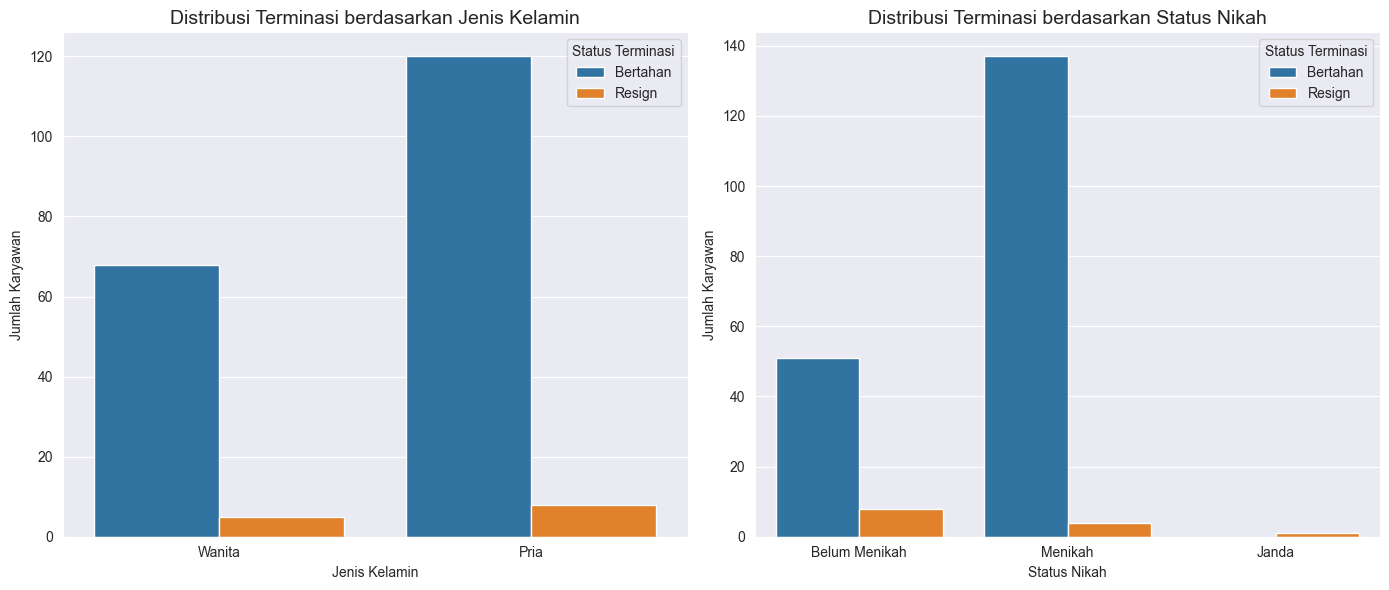

In [24]:
# Define mapping dictionaries
terminated_map = {0: 'Bertahan', 1: 'Resign'}
sex_map = {0: 'Pria', 1: 'Wanita'}
nikah_map = {0: 'Belum Menikah', 1: 'Janda', 2: 'Menikah'}

# Create new columns for plotting
excel_plot = excel.copy()
excel_plot['TERMINATED_LABEL'] = excel_plot['TERMINATED'].map(terminated_map)
excel_plot['JENIS_KELAMIN_LABEL'] = excel_plot['JENIS_KELAMIN'].map(sex_map)
excel_plot['STS_NIKAH_LABEL'] = excel_plot['STS_NIKAH'].map(nikah_map)

categorical_features = [
    ('JENIS_KELAMIN_LABEL', 'Jenis Kelamin'),
    ('STS_NIKAH_LABEL', 'Status Nikah')
]
rows, cols = 1, 2

plt.figure(figsize=(14, 6))
for i, (feature, label) in enumerate(categorical_features, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=excel_plot, x=feature, hue='TERMINATED_LABEL')
    plt.title(f'Distribusi Terminasi berdasarkan {label}', fontsize=14)
    plt.ylabel('Jumlah Karyawan')
    plt.xlabel(label)
    plt.legend(title='Status Terminasi')
    plt.tight_layout()
plt.show()

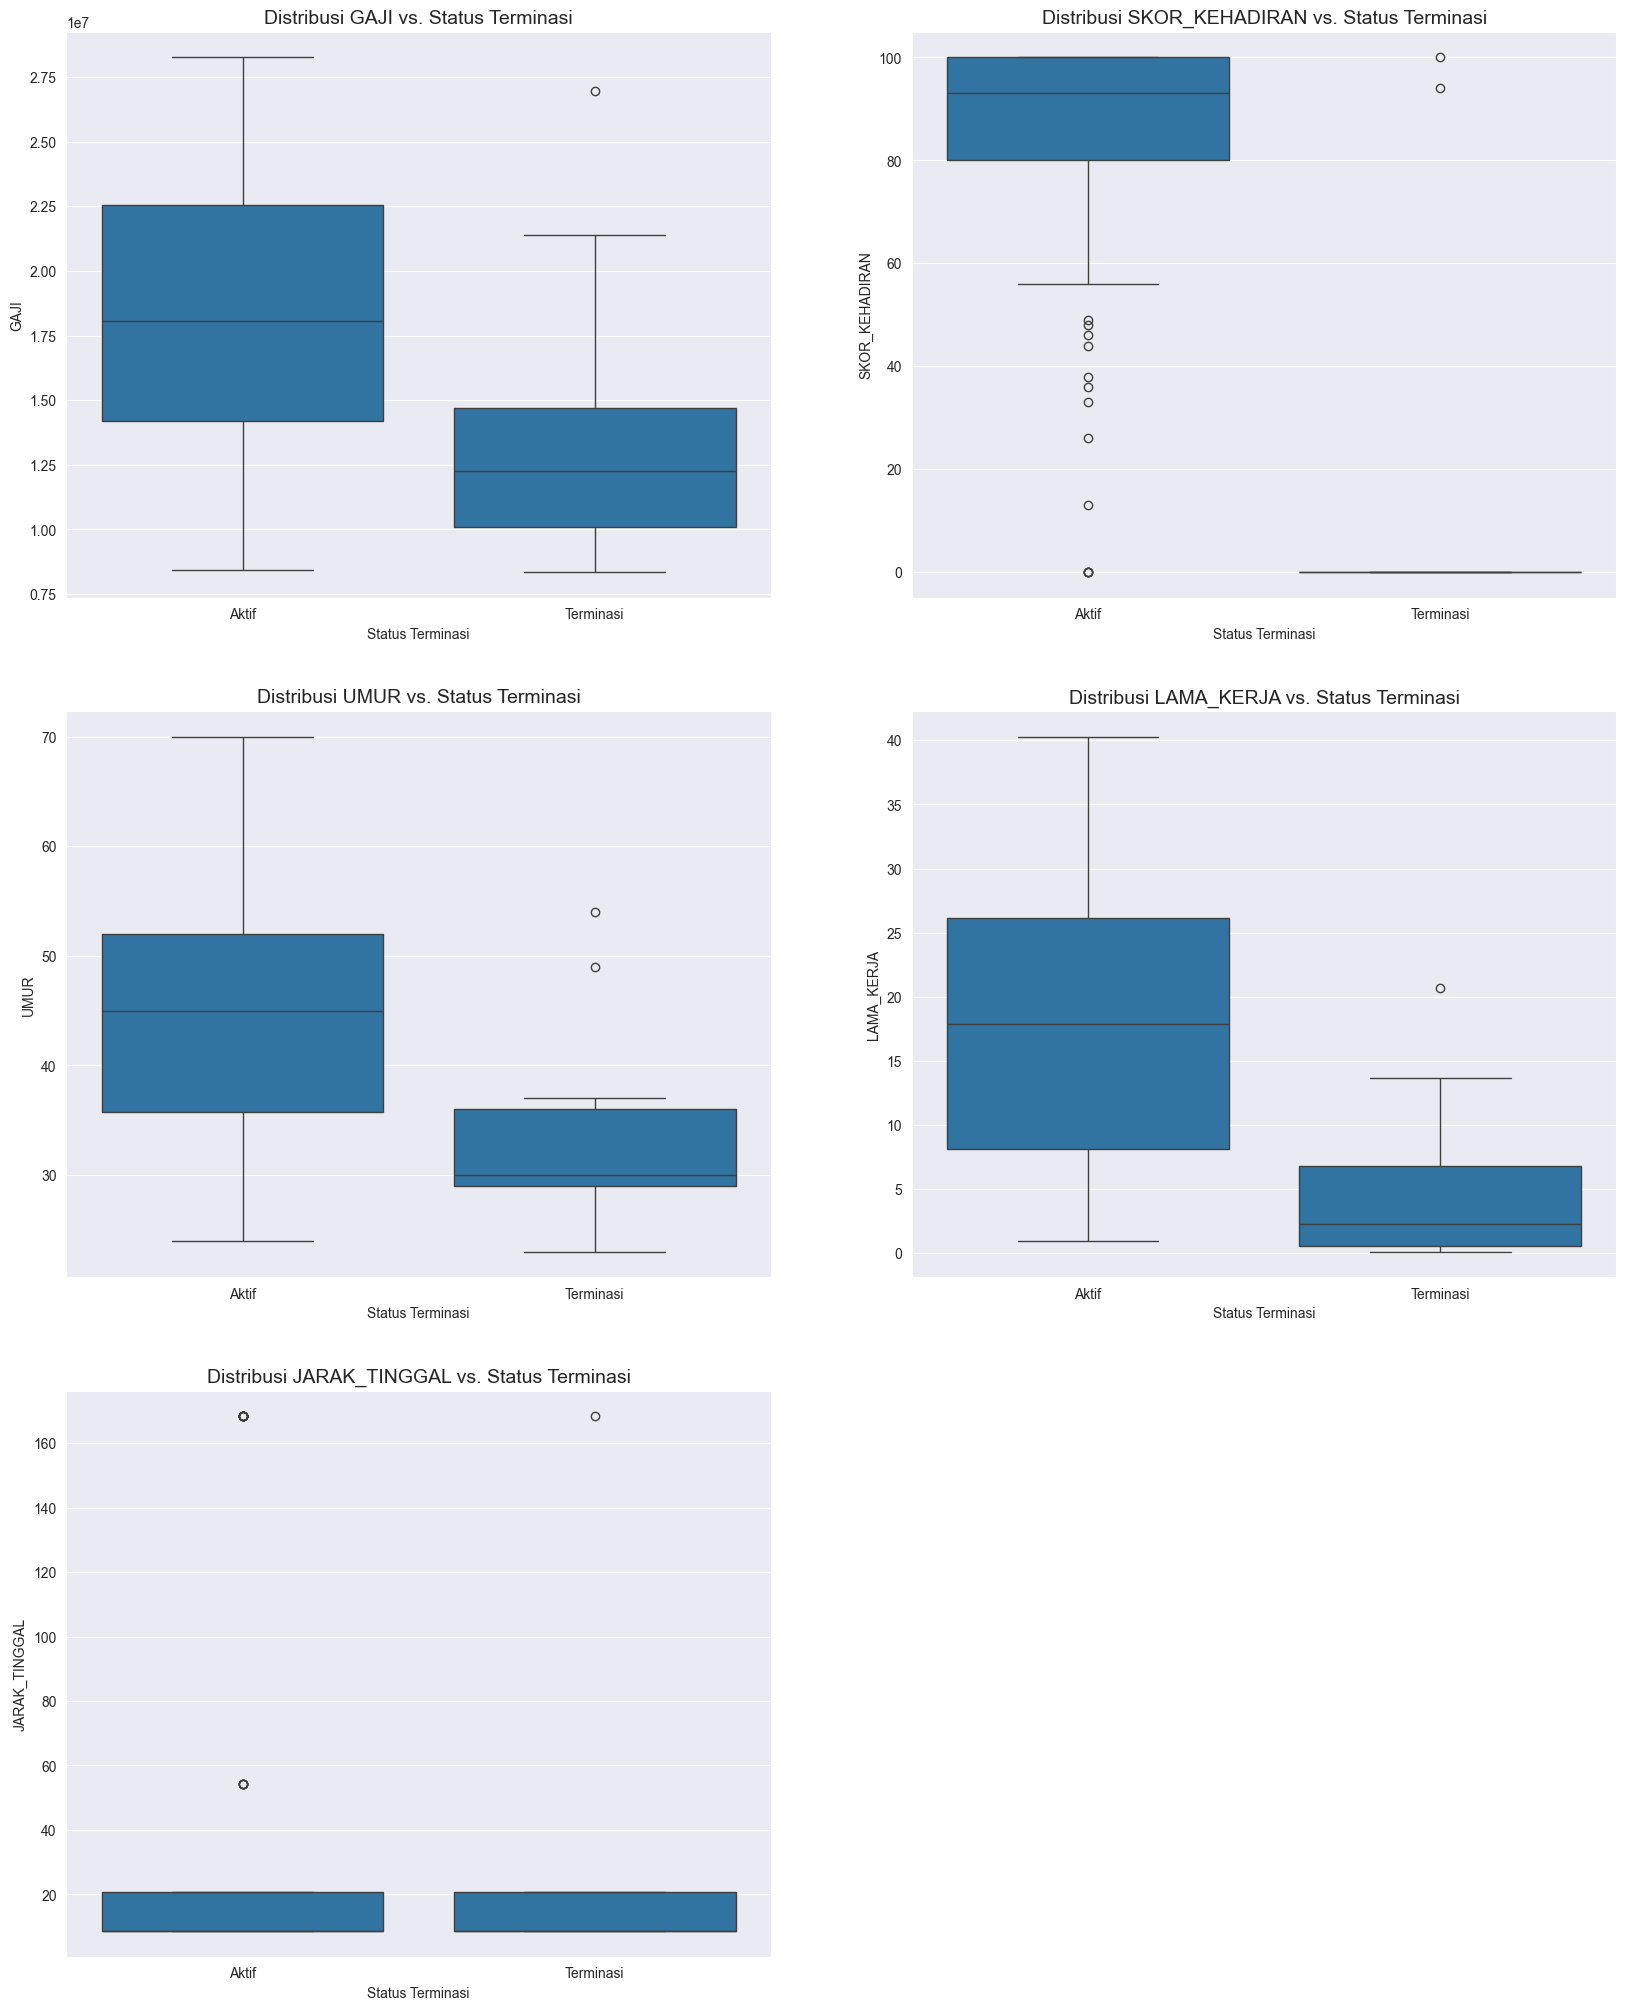

In [25]:
# Ganti 'df' dengan nama DataFrame Anda
numerical_features = ['GAJI', 'SKOR_KEHADIRAN', 'UMUR', 'LAMA_KERJA', 'JARAK_TINGGAL']

rows = 3
cols = 2

plt.figure(figsize=(20, 25))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(data=excel, x='TERMINATED', y=feature)
    plt.title(f'Distribusi {feature} vs. Status Terminasi', fontsize=14)
    plt.xlabel('Status Terminasi')
    plt.ylabel(feature)
    # Anda bisa mengganti label '0' dan '1' agar lebih deskriptif
    plt.xticks(ticks=[0, 1], labels=['Aktif', 'Terminasi'])
plt.show()

In [26]:
excel.describe()

,UMUR,JENIS_KELAMIN,STS_NIKAH,TERMINATED,LAMA_KERJA,GAJI,PENILAIAN_KINERJA,SKOR_KEHADIRAN,JARAK_TINGGAL
count,201.000000,201.000000,201.000000,201.000000,201.000000,2.010000e+02,201.000000,201.000000,201.000000
mean,43.358209,0.363184,1.407960,0.064677,16.728458,1.800249e+07,2.972537,81.069652,24.567662
std,10.711258,0.482118,0.912544,0.246568,10.810681,5.285115e+06,0.751639,27.886468,41.781323
min,23.000000,0.000000,0.000000,0.000000,0.130000,8.350000e+06,1.000000,0.000000,8.650000
25%,35.000000,0.000000,0.000000,0.000000,7.270000,1.405000e+07,3.030000,76.000000,8.650000
50%,44.000000,0.000000,2.000000,0.000000,16.310000,1.780000e+07,3.270000,92.000000,8.650000
75%,52.000000,1.000000,2.000000,0.000000,25.820000,2.235000e+07,3.390000,100.000000,20.900000
max,70.000000,1.000000,2.000000,1.000000,40.270000,2.825000e+07,3.600000,100.000000,168.360000


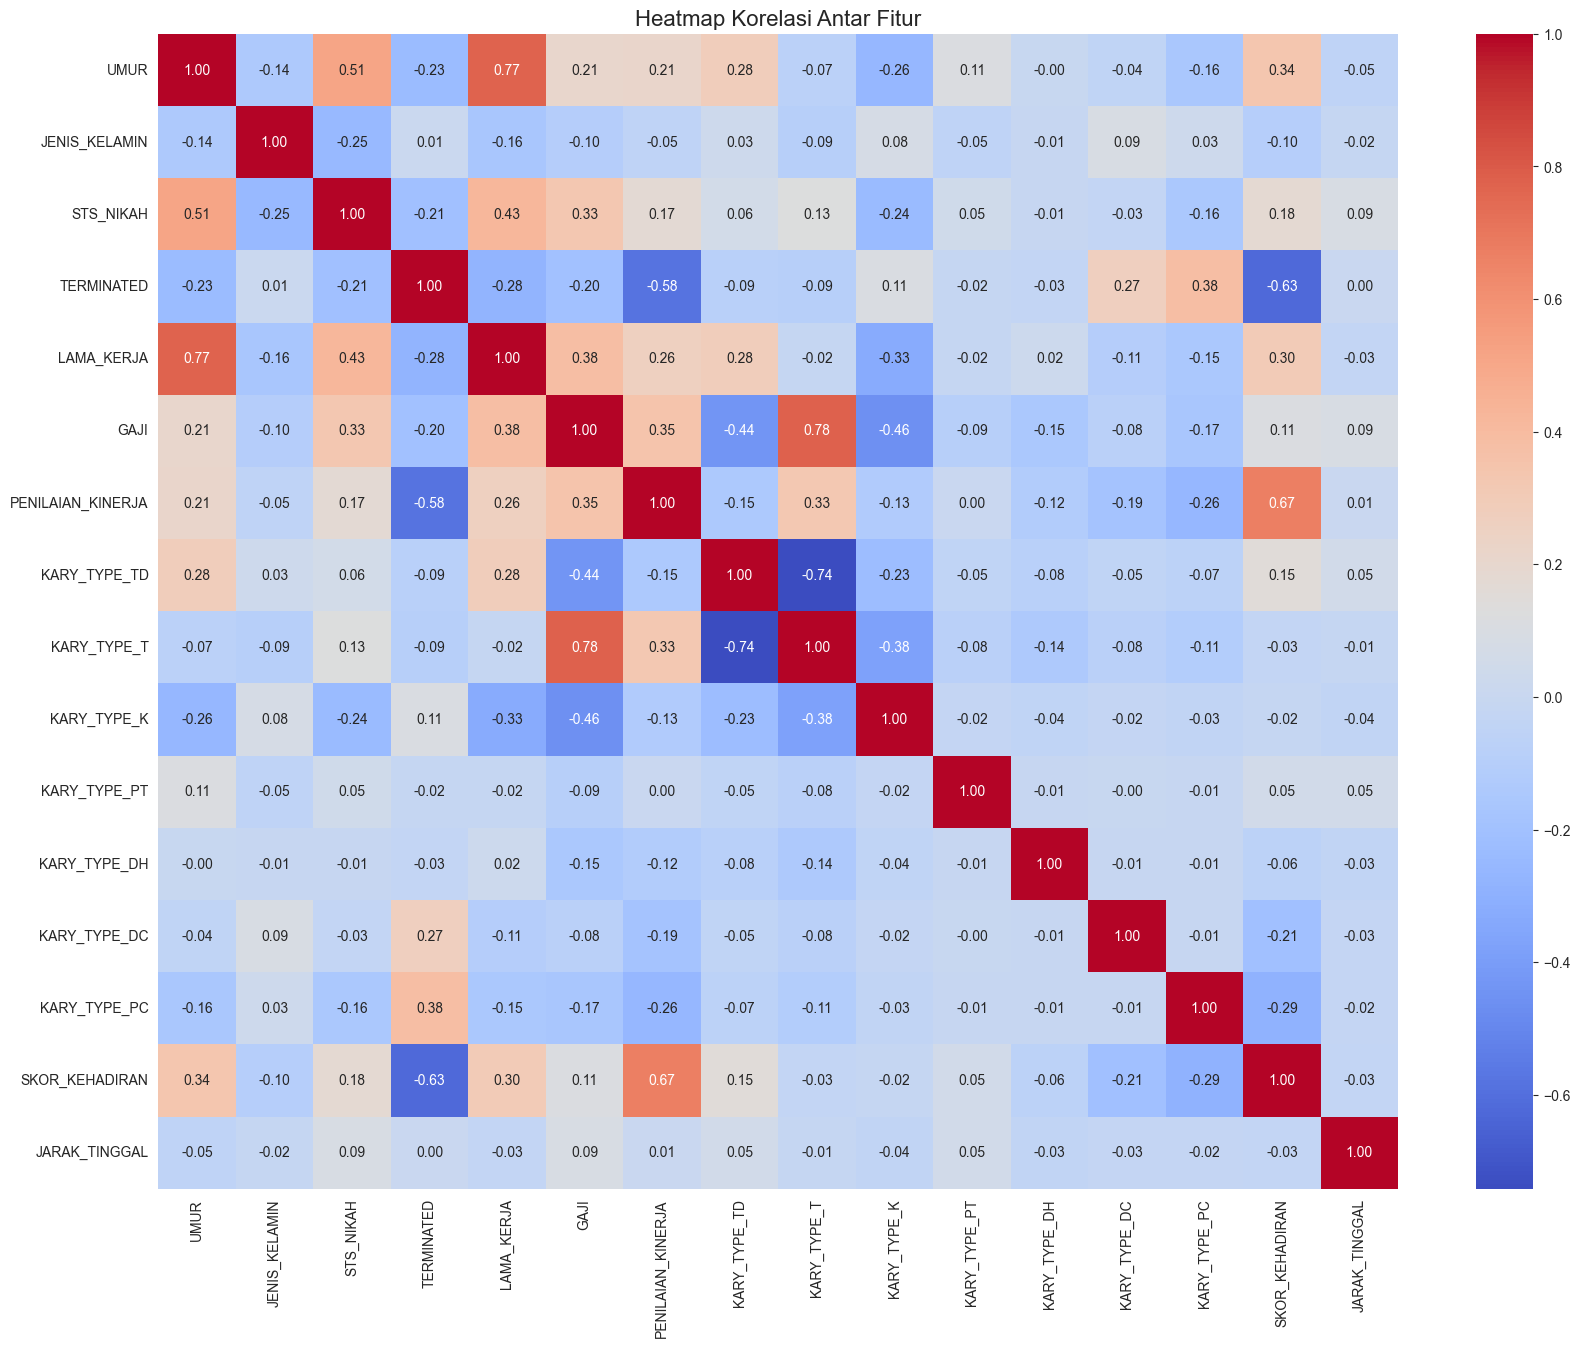

In [27]:
plt.figure(figsize=(20, 15))
data_correlation = excel.drop(['KARY_TYPE_I'], axis=1).corr()
sns.heatmap(data_correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Antar Fitur', fontsize=16)
plt.show()

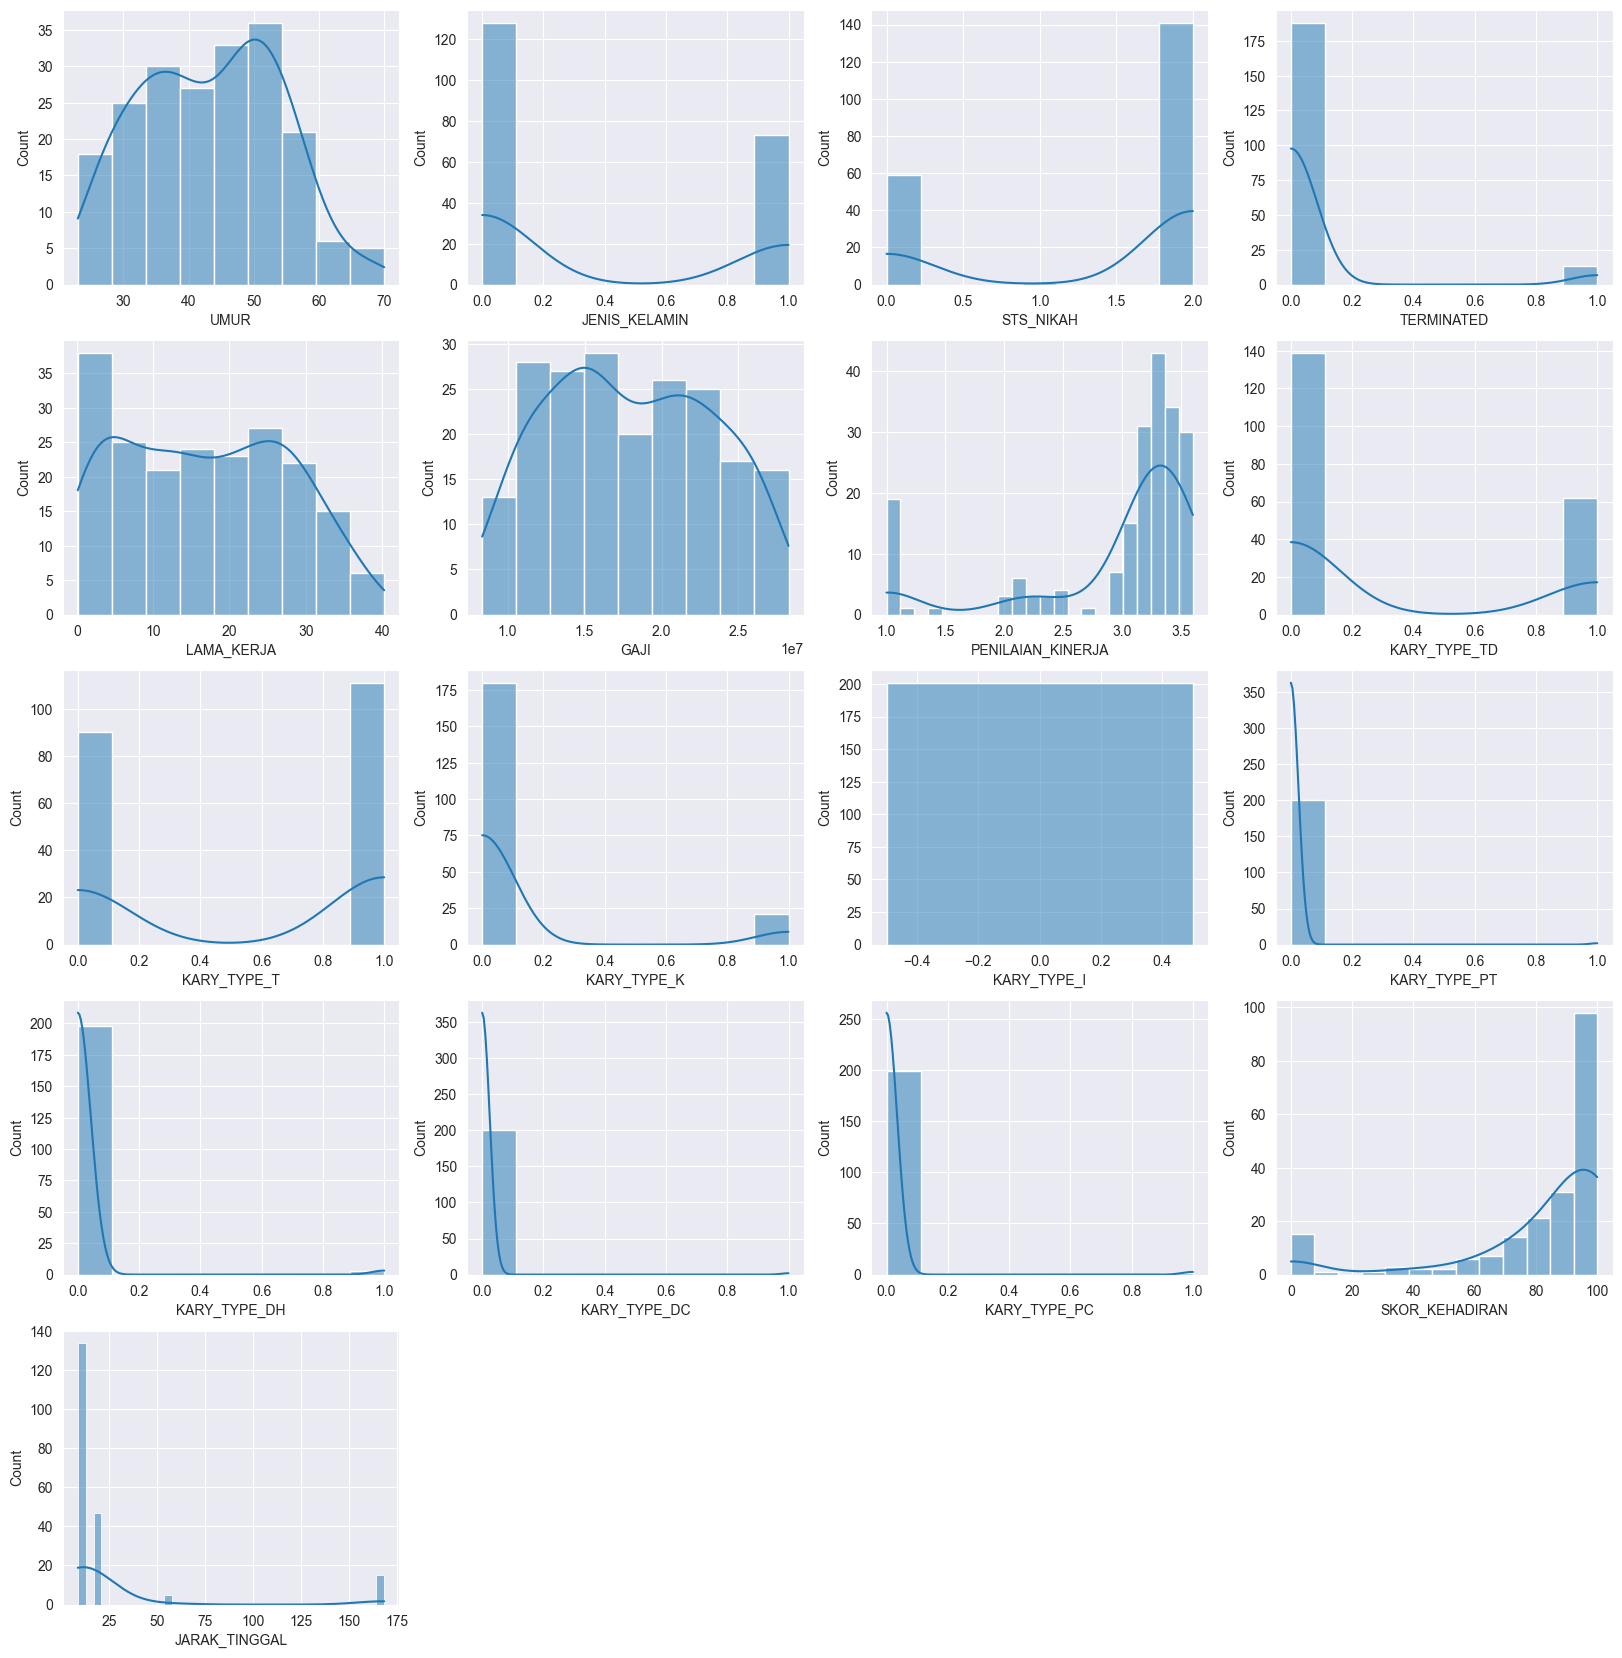

In [28]:
features = [feature for feature in excel.columns if feature != 'Terminated']

rows = 6
cols = 4
plt.figure(figsize=(20, 25))
for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data=excel, x=feature, kde=True, palette='muted', multiple='stack')
    # plt.title(feature)

## Data Splitting

### Set Random State

In [29]:
random_state = 7

In [30]:
excel['TERMINATED'].value_counts()

TERMINATED
0    188
1     13
Name: count, dtype: int64

In [70]:
# # Tidak perlu dimasukkan karena ini adalah penyesuaian agar sesuai dengan data real. Untuk saat ini, data yang digunakan adalah data dummy.
# percentages = [0.05, 0.10, 0.15, 0.20]
# datasets = {}
# percentage = percentages[1] # Change this to select different percentages
#
# # Separate positive and negative cases
# positive = excel[excel['Terminated'] == 1]
# negative = excel[excel['Terminated'] == 0]
#
# # Set the number of non-turnover samples you want
# n_non_turnover = 200
#
# # Sample non-turnover employees
# sampled_non_turnover = negative.sample(n=n_non_turnover, random_state=random_state)
#
# # for pct in percentages:
# n_pos = int(percentage * len(sampled_non_turnover))
# sampled_pos = positive.sample(n=n_pos, random_state=42)
# combined = pd.concat([sampled_non_turnover, sampled_pos]).sample(frac=1, random_state=random_state).reset_index(drop=True)

In [71]:
# combined.groupby('Terminated').size()

Terminated
0    200
1     20
dtype: int64

### Split Data X dan y

In [31]:
X = excel.drop('TERMINATED', axis=1)
y = excel['TERMINATED']

In [99]:
dtrain = xgboost.DMatrix(X, label=y)

### Cross-Validation Setup

In [32]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

## Model Implementation

### Set Parameters

In [33]:
parameters = {
    'objective':'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.1,
    'max_depth': 3,
    'seed': random_state,
    'n_estimators': 100,
}

# param_grid = {
#     'max_depth': [3, 4, 5],             # Batasi kedalaman pohon, jangan terlalu dalam
#     'learning_rate': [0.1, 0.05, 0.01], # Laju belajar yang lebih kecil
#     'n_estimators': [100, 200, 300],    # Jumlah pohon
#     'gamma': [0, 0.1, 0.2],             # Parameter regularisasi untuk mengontrol kompleksitas
#     'subsample': [0.8, 0.9],            # Persentase sampel data untuk setiap pohon
#     'colsample_bytree': [0.8, 0.9]      # Persentase fitur (kolom) untuk setiap pohon
# }

In [22]:
# xgboost1 = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')

In [19]:
# from sklearn.model_selection import GridSearchCV
#
# grid_search = GridSearchCV(
#     estimator=xgboost1,
#     param_grid=param_grid,
#     scoring='f1',
#     n_jobs=-1,
#     cv=kfold,
#     verbose=2)

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [ ]:
# grid_search.fit(X_train, y_train)

In [ ]:
# # 6. Lihat parameter terbaik yang ditemukan
# print("Best parameters found: ", grid_search.best_params_)
#
# # 7. Gunakan model terbaik untuk prediksi
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

### Train Model

In [ ]:
accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
accuracy_train_scores, precision_train_scores, recall_train_scores, f1_train_scores = [], [], [], []

# Cross-validation manual
for train_idx, val_idx in kfold.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    dtrain_fold = xgboost.DMatrix(X_train_fold, label=y_train_fold)
    dval_fold = xgboost.DMatrix(X_val_fold, label=y_val_fold)

    # xgb_classifier.fit(X_train_fold, y_train_fold)

    # Train model di fold ini
    xgb_model = xgboost.train(
        params={
            'objective':'binary:logistic',
            'eval_metric': 'logloss',
            'learning_rate': 0.1,
            'max_depth': 3,
            'seed': random_state,
            'n_estimators': 100,
        },
        dtrain=dtrain_fold,
        num_boost_round=parameters['n_estimators']
    )

    # Prediksi (returns probabilities for binary classification)
    y_pred_proba = xgb_model.predict(dval_fold)
    y_pred_train_proba = xgb_model.predict(dtrain_fold)
    # Convert probabilities to binary predictions
    y_pred_fold = (y_pred_proba > 0.5).astype(int)
    y_pred_train_fold = (y_pred_train_proba > 0.5).astype(int)

    # Simpan metrik
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_fold))
    precision_scores.append(precision_score(y_val_fold, y_pred_fold, average='weighted'))
    recall_scores.append(recall_score(y_val_fold, y_pred_fold, average='weighted'))
    f1_scores.append(f1_score(y_val_fold, y_pred_fold, average='weighted'))
    accuracy_train_scores.append(accuracy_score(y_train_fold, y_pred_train_fold))
    precision_train_scores.append(precision_score(y_train_fold, y_pred_train_fold, average='weighted'))
    recall_train_scores.append(recall_score(y_train_fold, y_pred_train_fold, average='weighted'))
    f1_train_scores.append(f1_score(y_train_fold, y_pred_train_fold, average='weighted'))

## Model Evaluation

In [52]:
# Ambil rata-rata dari tiap metrik
accuracy = np.mean(accuracy_scores)
precision = np.mean(precision_scores)
recall = np.mean(recall_scores)
f1 = np.mean(f1_scores)

# Menampilkan hasil
print(f"Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"Precision: %.2f%%" % (precision * 100.0))
print(f"Recall: %.2f%%" % (recall * 100.0))
print(f"F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 97.51%
Precision: 97.87%
Recall: 97.51%
F1 Score: 97.31%


In [53]:
# Ambil rata-rata dari tiap metrik
accuracy_train = np.mean(accuracy_train_scores)
precision_train = np.mean(precision_train_scores)
recall_train = np.mean(recall_train_scores)
f1_train = np.mean(f1_train_scores)

# Menampilkan hasil
print(f"Accuracy: %.2f%%" % (accuracy_train * 100.0))
print(f"Precision: %.2f%%" % (precision_train * 100.0))
print(f"Recall: %.2f%%" % (recall_train * 100.0))
print(f"F1 Score: %.2f%%" % (f1_train * 100.0))

Accuracy: 98.88%
Precision: 98.89%
Recall: 98.88%
F1 Score: 98.83%


## Save Model

In [54]:
xgb_model.save_model('xgboost_model.json')

In [34]:
accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
accuracy_train_scores, precision_train_scores, recall_train_scores, f1_train_scores = [], [], [], []

# Cross-validation manual
for train_idx, val_idx in kfold.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    dtrain_fold = xgboost.DMatrix(X_train_fold, label=y_train_fold)
    dval_fold = xgboost.DMatrix(X_val_fold, label=y_val_fold)

    # Train model di fold ini
    # xgb_classifier.fit(X_train_fold, y_train_fold)
    xgb_model = xgboost.Booster()
    xgb_model.load_model('xgboost_model.json')

    # Prediksi (returns probabilities for binary classification)
    y_pred_proba = xgb_model.predict(dval_fold)
    y_pred_train_proba = xgb_model.predict(dtrain_fold)
    # Convert probabilities to binary predictions
    y_pred_fold = (y_pred_proba > 0.5).astype(int)
    y_pred_train_fold = (y_pred_train_proba > 0.5).astype(int)

    # Simpan metrik
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_fold))
    precision_scores.append(precision_score(y_val_fold, y_pred_fold, average='weighted'))
    recall_scores.append(recall_score(y_val_fold, y_pred_fold, average='weighted'))
    f1_scores.append(f1_score(y_val_fold, y_pred_fold, average='weighted'))
    accuracy_train_scores.append(accuracy_score(y_train_fold, y_pred_train_fold))
    precision_train_scores.append(precision_score(y_train_fold, y_pred_train_fold, average='weighted'))
    recall_train_scores.append(recall_score(y_train_fold, y_pred_train_fold, average='weighted'))
    f1_train_scores.append(f1_score(y_train_fold, y_pred_train_fold, average='weighted'))

In [35]:
# Ambil rata-rata dari tiap metrik
accuracy = np.mean(accuracy_scores)
precision = np.mean(precision_scores)
recall = np.mean(recall_scores)
f1 = np.mean(f1_scores)

# Menampilkan hasil
print(f"Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"Precision: %.2f%%" % (precision * 100.0))
print(f"Recall: %.2f%%" % (recall * 100.0))
print(f"F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 98.51%
Precision: 98.58%
Recall: 98.51%
F1 Score: 98.23%


In [36]:
# Ambil rata-rata dari tiap metrik
accuracy_train = np.mean(accuracy_train_scores)
precision_train = np.mean(precision_train_scores)
recall_train = np.mean(recall_train_scores)
f1_train = np.mean(f1_train_scores)

# Menampilkan hasil
print(f"Accuracy: %.2f%%" % (accuracy_train * 100.0))
print(f"Precision: %.2f%%" % (precision_train * 100.0))
print(f"Recall: %.2f%%" % (recall_train * 100.0))
print(f"F1 Score: %.2f%%" % (f1_train * 100.0))

Accuracy: 98.51%
Precision: 98.53%
Recall: 98.51%
F1 Score: 98.41%


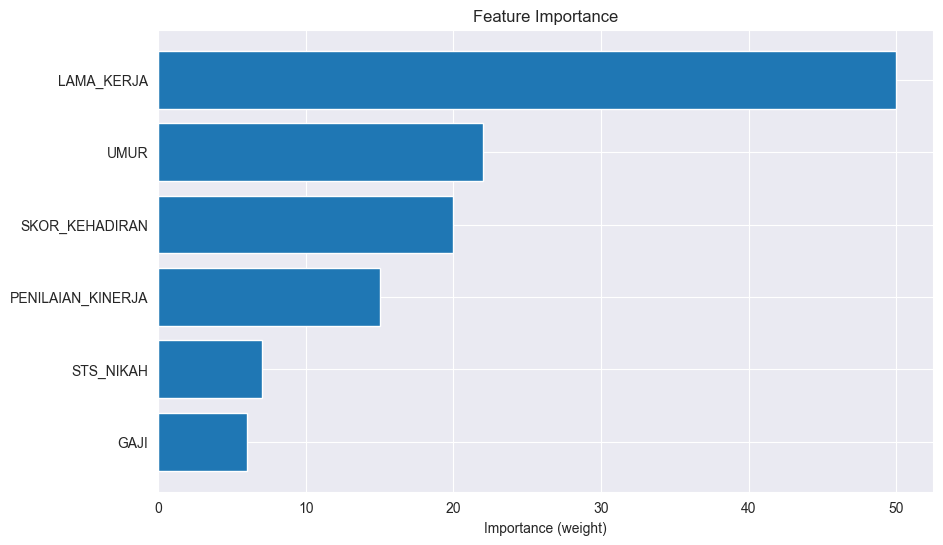

In [37]:
# Load model
xgb_model = xgboost.Booster()
xgb_model.load_model('xgboost_model.json')

# Get feature importance (by weight)
importance = xgb_model.get_score(importance_type='weight')

# Optional: Map feature indices to column names if using DMatrix
feature_names = X.columns
# importance = {feature_names[int(k[1:])]: v for k, v in importance.items()}

# Sort and plot
sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.barh(list(sorted_importance.keys()), list(sorted_importance.values()))
plt.xlabel('Importance (weight)')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()